# Barrow climate data

This is a small analysis of Barrow daily weather summaries sourced from [NOAA](https://www.ncdc.noaa.gov/cdo-web/datasets).

I was inspired to look at Barrow weather data by reading in the [Washington Post](https://www.washingtonpost.com/news/capital-weather-gang/wp/2017/12/12/barrow-is-warming-so-fast-algorithms-removed-the-data-because-it-seemed-unreal/?utm_term=.7a5b322526b4) about how the data there was setting off outlier detection climate models and reading an excellent [climate.gov article](https://www.climate.gov/news-features/understanding-climate/barrow-alaska-climate-change-action) about rising average temperatures for October .

In [213]:
import pandas as pd
import numpy as np
import datetime as dt

In [10]:
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
%matplotlib inline

In [273]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
lowess = sm.nonparametric.lowess

### Read in historical daily weather summaries at Barrow from NOAA

In [286]:
barrow = pd.read_csv("barrowAK_daily.csv")
barrow = barrow[['STATION','NAME','LATITUDE','LONGITUDE',
 'DATE','AWND','PRCP','SNOW','TMIN','TAVG','TMAX']]
barrow['DATE'] = pd.to_datetime(barrow['DATE'])

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (7,9,11,13,15,23,29,31,33,35,37,39,41,43,45,47,49,51,55,57,59,61,63,65,69,71,73,75,77,79,81,83,85,87,89,91,93) have mixed types. Specify dtype option on import or set low_memory=False.



In [297]:
barrow['month'] = barrow['DATE'].apply(lambda x: x.month)
barrow['year'] = barrow['DATE'].apply(lambda x: x.year)
start_date = np.min(barrow['DATE'])
barrow['daynr'] = (barrow['DATE'] - start_date)
barrow['daynr'] = barrow['daynr'].apply(lambda x: x.days)
barrow.head()

,STATION,NAME,LATITUDE,LONGITUDE,DATE,AWND,PRCP,SNOW,TMIN,TAVG,TMAX,month,year,daynr
0,USW00027502,"BARROW W POST W ROGERS AIRPORT, AK US",71.2834,-156.7815,1901-09-01,NaN,0.00,0.0,30.0,NaN,38.0,9,1901,0
1,USW00027502,"BARROW W POST W ROGERS AIRPORT, AK US",71.2834,-156.7815,1901-09-02,NaN,0.00,0.0,29.0,NaN,41.0,9,1901,1
2,USW00027502,"BARROW W POST W ROGERS AIRPORT, AK US",71.2834,-156.7815,1901-09-03,NaN,0.00,NaN,29.0,NaN,39.0,9,1901,2
3,USW00027502,"BARROW W POST W ROGERS AIRPORT, AK US",71.2834,-156.7815,1901-09-04,NaN,0.00,NaN,32.0,NaN,40.0,9,1901,3
4,USW00027502,"BARROW W POST W ROGERS AIRPORT, AK US",71.2834,-156.7815,1901-09-05,NaN,0.03,NaN,32.0,NaN,46.0,9,1901,4


In [6]:
print(barrow['DATE'].min(),barrow['DATE'].max())

1901-09-01 00:00:00 2017-12-27 00:00:00


This data is from the Barrow airport weather station and spans from Sept 1901 to Dec 2017.

### Show Barrow location on map
Let’s look at where Barrow is on map of Alaska with the Arctic Circle (66.33 degrees latitude) shown:

In [52]:
pd.unique(barrow['LATITUDE'])[0],pd.unique(barrow['LONGITUDE'])[0]

(71.2834, -156.7815)

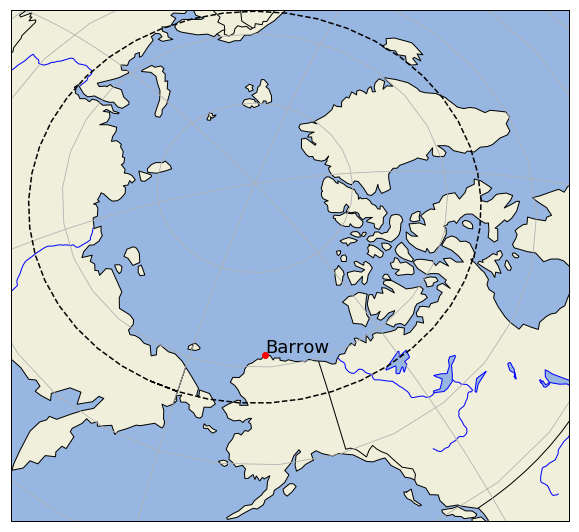

In [198]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(-160, 60))

ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS, zorder=0, edgecolor='blue')
ax.add_feature(cartopy.feature.LAKES, zorder=0, edgecolor='blue')
ax.add_feature(cartopy.feature.BORDERS, zorder=0)
ax.gridlines()
ax.set_extent((-100,-190,50,120))
#ax.set_global()

barrow_lon,barrow_lat = -156.7815,71.2834
ax.scatter(barrow_lon,barrow_lat,color='red', marker='o',transform=ccrs.Geodetic(), zorder=2)
ax.text(barrow_lon+.25,barrow_lat+0.25, 'Barrow',horizontalalignment='left',size=18,transform=ccrs.Geodetic())

# draw Arctic circle
ax.plot(list(range(180,-190,-8)),np.repeat(66.33,47),'k--',transform=ccrs.Geodetic())

## Exploring the temperature record at Barrow

There are large gaps in the observations in the earlier years of the data:

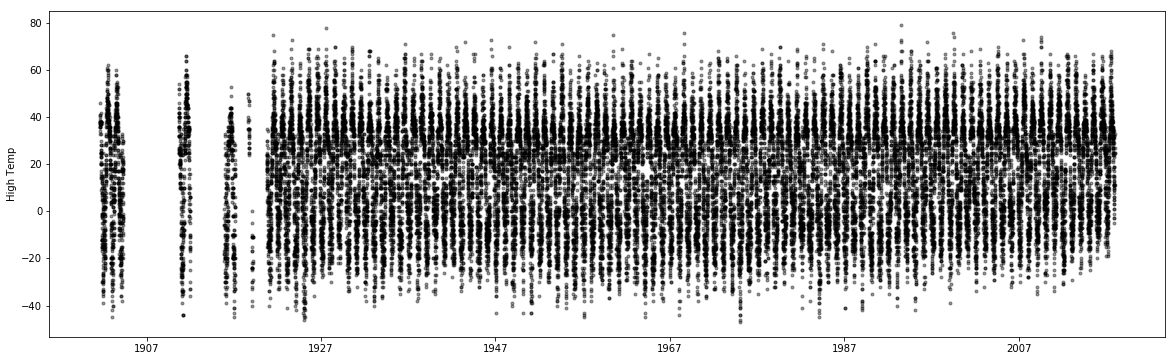

In [205]:
plt.figure(figsize=(20,6))
plt.plot(barrow['DATE'],barrow['TMAX'],'k.',alpha=0.4)
plt.ylabel("High Temp")

From October 1920 on is available without any major gaps in the data.

Examining the last several years of high temperatures:

In [235]:
barrow_recent = barrow[barrow['DATE']>dt.datetime.strptime('2012-01-01','%Y-%m-%d').date()]
tmax_sm_recent = lowess(barrow_recent['TMAX'],barrow_recent['daynr'],frac=2./3,return_sorted=False)

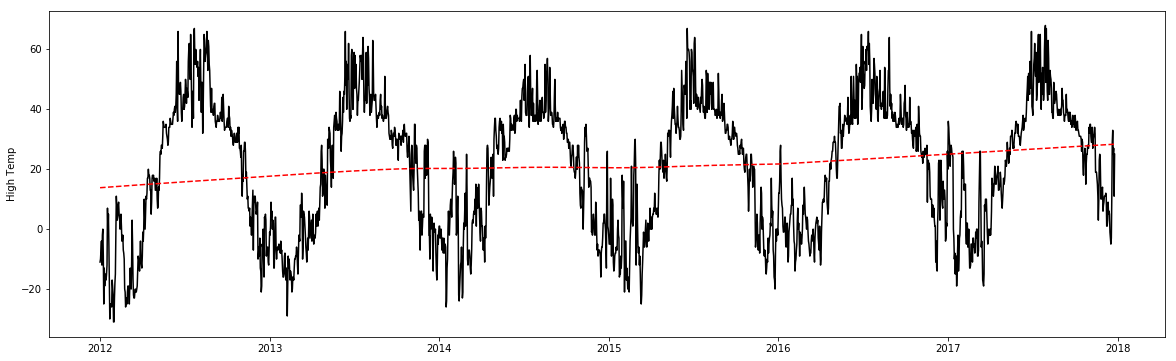

In [236]:
plt.figure(figsize=(20,6))
plt.plot(barrow_recent['DATE'],barrow_recent['TMAX'],'k-')
plt.plot(barrow_recent['DATE'],tmax_sm_recent,'r--')
plt.ylabel("High Temp")

Following the climate.gov article, let’s look at monthly averages over time starting in Oct 1920:

In [238]:
monthly_averages = barrow[barrow['DATE']>dt.datetime.strptime('1920-10-01','%Y-%m-%d').date()
    ].groupby(
    ['month','year'])[['TMIN','TMAX','PRCP','AWND']
    ].mean().reset_index()
monthly_averages.head()

,month,year,TMIN,TMAX,PRCP,AWND
0,1,1921,-26.000000,-10.064516,0.006452,NaN
1,1,1922,-13.483871,-1.516129,0.004194,NaN
2,1,1923,-30.806452,-17.387097,0.000000,NaN
3,1,1924,-26.870968,-14.451613,0.015161,NaN
4,1,1925,-36.870968,-21.612903,0.003871,NaN


 Examine Fall-Winter month average high temperatures over time

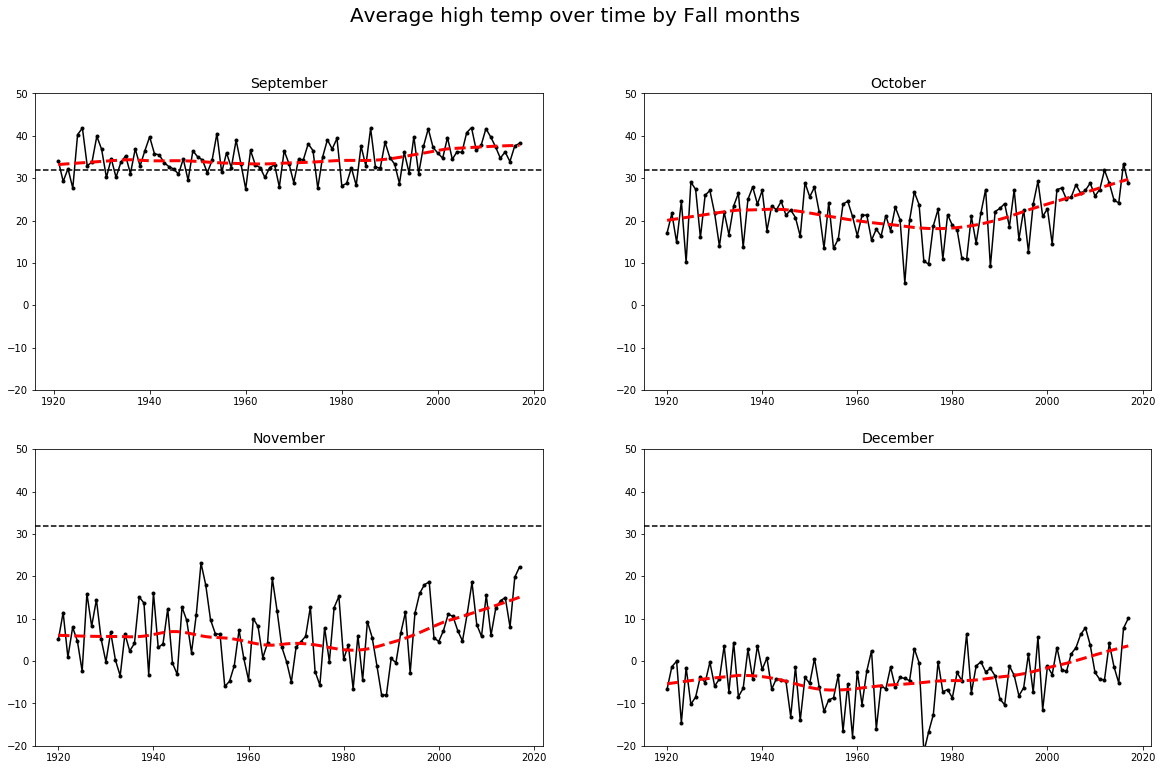

In [264]:
plt.figure(figsize=(20,12))
plt.suptitle('Average high temp over time by Fall months',size=20)

plt.subplot(221)
plt.title("September",size=14)
plt.axhline(y=32,color='black',linestyle='dashed')
plt.ylim([-20,50])
sept_monthly = monthly_averages[monthly_averages['month']==9]
plt.plot(sept_monthly['year'],sept_monthly['TMAX'],'k.-')
plt.plot(sept_monthly['year'],lowess(sept_monthly['TMAX'],sept_monthly['year'],frac=1./3,return_sorted=False),'r--',linewidth=3)

plt.subplot(222)
plt.title("October",size=14)
plt.axhline(y=32,color='black',linestyle='dashed')
plt.ylim([-20,50])
oct_monthly = monthly_averages[monthly_averages['month']==10]
plt.plot(oct_monthly['year'],oct_monthly['TMAX'],'k.-')
plt.plot(oct_monthly['year'],lowess(oct_monthly['TMAX'],oct_monthly['year'],frac=1./3,return_sorted=False),'r--',linewidth=3)

plt.subplot(223)
plt.title("November",size=14)
plt.axhline(y=32,color='black',linestyle='dashed')
plt.ylim([-20,50])
nov_monthly = monthly_averages[monthly_averages['month']==11]
plt.plot(nov_monthly['year'],nov_monthly['TMAX'],'k.-')
plt.plot(nov_monthly['year'],lowess(nov_monthly['TMAX'],nov_monthly['year'],frac=1./3,return_sorted=False),'r--',linewidth=3)

plt.subplot(224)
plt.title("December",size=14)
plt.axhline(y=32,color='black',linestyle='dashed')
plt.ylim([-20,50])
dec_monthly = monthly_averages[monthly_averages['month']==12]
plt.plot(dec_monthly['year'],dec_monthly['TMAX'],'k.-')
plt.plot(dec_monthly['year'],lowess(dec_monthly['TMAX'],dec_monthly['year'],frac=1./3,return_sorted=False),'r--',linewidth=3)

Examine yearly average temps

In [265]:
yearly_averages = barrow[barrow['DATE']>dt.datetime.strptime('1921-01-01','%Y-%m-%d').date()
    ].groupby(
    ['year'])[['TMIN','TMAX','PRCP','AWND']
    ].mean().reset_index()
yearly_averages.head()

,year,TMIN,TMAX,PRCP,AWND
0,1921,4.038462,16.928571,0.011016,NaN
1,1922,2.813699,14.681319,0.019341,NaN
2,1923,3.069832,15.824176,0.037299,NaN
3,1924,-1.240437,11.666667,0.015437,NaN
4,1925,1.450549,14.909091,0.022936,NaN


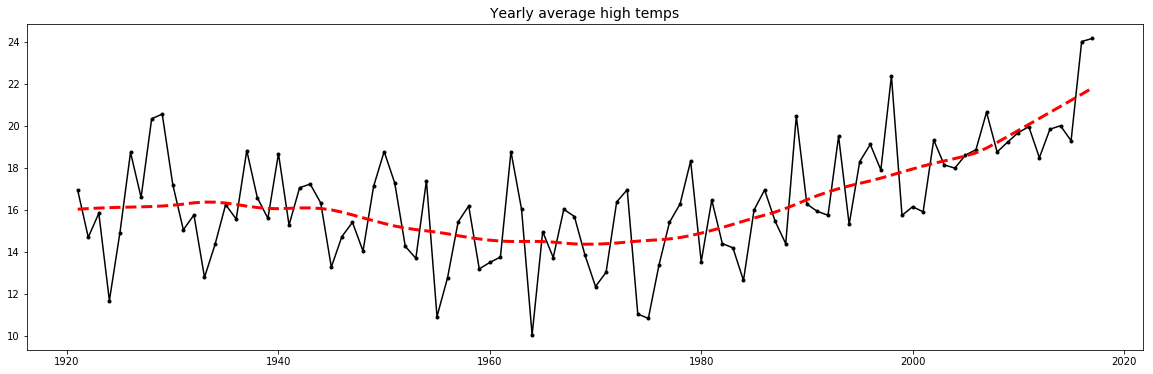

In [271]:
plt.figure(figsize=(20,6))
plt.plot(yearly_averages['year'],yearly_averages['TMAX'],'k.-')
plt.plot(yearly_averages['year'],lowess(yearly_averages['TMAX'],yearly_averages['year'],frac=1./4,return_sorted=False),'r--',linewidth=3)
plt.title("Yearly average high temps",size=14)

Plots of high temperatures over time show a clear rising trend in the last few decades. 

Let's test that with a simple regression model:

In [302]:
barrow_complete = barrow[barrow['DATE']>dt.datetime.strptime('1920-10-01','%Y-%m-%d').date()]
barrow_complete['time_yrs'] = barrow_complete['daynr']/365

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [329]:
results = smf.ols('TMAX ~ time_yrs*year>1980+C(month)', data=barrow_complete).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TMAX   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     9185.
Date:                Mon, 22 Jan 2018   Prob (F-statistic):               0.00
Time:                        00:30:25   Log-Likelihood:            -1.3453e+05
No. Observations:               35450   AIC:                         2.691e+05
Df Residuals:                   35435   BIC:                         2.692e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -6.6036      0.287    -22.985      0.000      -7.167      -6.041
year > 1980[T.True]            -16.6103      0.882    -18.841      0.000     -18.338     -14.882
C(month)[T.2]                   -2.9202      0.284    -10.271      0.000      -3.477      -2.363
C(month)[T.3]                    0.0491      0.279      0.176      0.860      -0.497       0.595
C(month)[T.4]                   14.8924      0.280     53.202      0.000      14.344      15.441
C(month)[T.5]                   32.4302      0.278    116.795      0.000      31.886      32.974
C(month)[T.6]                   46.6212      0.280    166.548      0.000      46.073      47.170
C(month)[T.7]                   53.5597      0.278    192.921      0.000      53.016      54.104
C(month)[T.8]                   50.8924      0.278    183.265      0.000      50.348      51.437
C(month)[T.9]                   42.2512      0.280    150.906      0.000      41.702      42.800
C(month)[T.10]                  28.8937      0.277    104.313      0.000      28.351      29.437
C(month)[T.11]                  13.9132      0.279     49.801      0.000      13.366      14.461
C(month)[T.12]                   3.4923      0.277     12.602      0.000       2.949       4.035
time_yrs                        -0.0390      0.004     -9.327      0.000      -0.047      -0.031
time_yrs:year > 1980[T.True]     0.2163      0.010     22.474      0.000       0.197       0.235
==============================================================================
Omnibus:                     1513.813   Durbin-Watson:                   0.462
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2103.283
Skew:                           0.424   Prob(JB):                         0.00
Kurtosis:                       3.839   Cond. No.                     1.41e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Indeed, there is a significant positive slope of 0.2163 degrees per year from 1980 

In [327]:
#plt.figure(figsize=(20,6))
#plt.plot(,results.fittedvalues,'r-')
#plt.plot(barrow_complete['daynr'],barrow_complete['TMAX'],'k.',alpha=0.4)

Explorations of precipitation and other intersting patterns

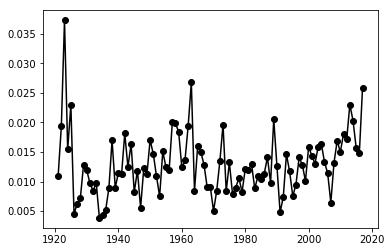

In [92]:
plt.plot(yearly_averages['year']
        ,yearly_averages['PRCP']
        ,'ko-')

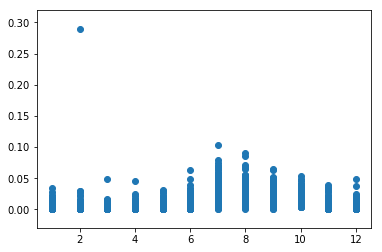

In [272]:
plt.scatter(monthly_averages['month'],monthly_averages['PRCP'])